In [1]:
!pip install optuna

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import packages

import io
import math
from datetime import datetime
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import pytz
import matplotlib.pyplot as plt
import optuna
from torch.utils.data import IterableDataset
from torch.optim.lr_scheduler import StepLR
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torchtext.vocab import build_vocab_from_iterator
from torch import nn, optim
from torch.optim import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


It modifies each password by adding special tokens '<sos>' (start of sequence) and <eos> (end of sequence) to the beginning and end of the password, respectively.
These tokens explicitly mark the boundaries of a password, helping the model to learn when a password begins and ends. This is crucial for the model to structure its output properly during generation.

In [ ]:
base_path = 'drive/MyDrive/CPS-Project/'

In [76]:
class PasswordDataset(Dataset):
    def __init__(self, path, limit=None):
        with open(path, 'r', encoding='latin1') as file:
            if limit is not None:
                self.passwords = [next(file).strip() for _ in range(limit) if next(file).strip()]
            else:
                self.passwords = [line.strip() for line in file if line.strip()]

    def __len__(self):
        return len(self.passwords)

    def __getitem__(self, idx):
        return self.passwords[idx]

def yield_tokens(data_iter):
    for password in data_iter:
        yield ['<sos>'] + list(password) + ['<eos>']

def store_best_params(study):
    # Get the best parameters
    best_params = study.best_params

    # Convert the best parameters to a DataFrame
    df = pd.DataFrame([best_params])

    # Get the current timezone
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")

    # Save the DataFrame to a CSV file with the timezone in its name
    file_name = f"params/best_params_{timestamp}.csv"
    df.to_csv(base_path + file_name, index=False)

def load_best_params(file_name):
    # Load the CSV file containing the best parameters
    best_params_df = pd.read_csv(file_name)

    # Convert DataFrame to dictionary
    best_params = best_params_df.to_dict(orient='records')[0]

    return best_params

In [77]:
def save_vocab(vocab, file_path):
    """
    Save a vocabulary object to a file using pickle.

    Args:
    vocab (Vocab): The vocabulary object.
    file_path (str): The path to the file where the vocabulary will be saved.
    """
    with open(file_path, 'wb') as f:
        pickle.dump(vocab, f)

def load_vocab(file_path):
    """
    Load a vocabulary object from a file using pickle.

    Args:
    file_path (str): The path to the file from which the vocabulary will be loaded.

    Returns:
    Vocab: The loaded vocabulary object.
    """
    with open(file_path, 'rb') as f:
        vocab = pickle.load(f)
    return vocab


In [78]:
# Load dataset
dataset = PasswordDataset(base_path + 'dataset/rockyou.txt', 16000)
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% of the data for training
validation_size = int(0.1 * total_size)  # 10% for validation
test_size = total_size - train_size - validation_size  # The rest for testing
train_dataset, validation_dataset, test_dataset = random_split(
    dataset, [train_size, validation_size, test_size])

# <unk>: Represents any unknown characters (out-of-vocabulary).
# <pad>: Used for padding shorter sequences to a common length in each batch.
vocab = build_vocab_from_iterator(yield_tokens(iter(train_dataset)), specials=['<unk>', '<pad>', '<sos>', '<eos>'])
vocab.set_default_index(vocab['<unk>'])
vocab_size = len(vocab)
save_vocab(vocab, base_path + 'vocab/vocab.pkl')

def collate_batch(batch):
    # Convert batch of raw strings into a batch of character indices
    data_list = [torch.tensor(vocab(list(p[:-1])), dtype=torch.long) for p in batch]  # All except the last character
    target_list = [torch.tensor(vocab(list(p[1:])), dtype=torch.long) for p in batch]  # All except the first character
    data_list = pad_sequence(data_list, padding_value=vocab['<pad>'], batch_first=True)
    target_list = pad_sequence(target_list, padding_value=vocab['<pad>'], batch_first=True)
    return data_list, target_list


batch_size = 32 # 128
# Assuming train_dataset, validation_dataset, test_dataset are defined properly
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)



In [79]:
print(len(train_loader))
print(len(test_loader))
print(len(validation_loader))
# number of batches in each loader

400
51
50


In [80]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, num_layers, dropout_rate, vocab_size, d_model=512, nhead=8):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.d_model = d_model
        self.nhead = nhead

        self.encoder = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout_rate)

        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=2048, dropout=dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        self.decoder = nn.Linear(d_model, vocab_size)

        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask=None):
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output


In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [87]:
def objective(trial):
    # Hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    num_layers = trial.suggest_int('num_layers', 1, 4)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # Predefined (d_model, nhead) combinations
    model_configs = [
        (128, 4), (256, 4), (256, 8), (512, 8),
        (128, 8), (320, 4), (320, 8), (512, 4)
    ]
    d_model, nhead = trial.suggest_categorical('model_config', model_configs)

    # Model initialization
    model = TransformerModel(num_layers=num_layers, dropout_rate=dropout_rate,
                             vocab_size=vocab_size, d_model=d_model, nhead=nhead)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.95)
    loss_function = nn.CrossEntropyLoss()

    num_epochs = 8
    for epoch in range(num_epochs):
        model.train()
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(data)
            output = output.transpose(1, 2)  # Change shape from [batch, seq_len, features] to [batch, features, seq_len]
            loss = loss_function(output, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

        model.eval()
        total_loss = 0
        with torch.no_grad():
            for data, targets in validation_loader:
                data, targets = data.to(device), targets.to(device)
                output = model(data)
                output = output.transpose(1, 2)  # Adjust output dimensions
                loss = loss_function(output, targets)
                total_loss += loss.item()

    return total_loss / len(validation_loader)

In [88]:
# Create a study object and specify the optimization direction as 'minimize'.
# Run Optuna optimization in parallel
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20, n_jobs=-1)  # Set n_jobs to -1 to use all available CPU cores

print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-04-22 00:04:28,317] A new study created in memory with name: no-name-c9984db9-6c16-4829-b751-691ee4d14486
[I 2024-04-22 00:05:04,610] Trial 5 finished with value: 1.5482598447799683 and parameters: {'lr': 0.0006886366645164576, 'num_layers': 1, 'dropout_rate': 0.1450038073174798, 'model_config': (256, 4)}. Best is trial 5 with value: 1.5482598447799683.
[I 2024-04-22 00:05:07,581] Trial 4 finished with value: 1.634001784324646 and parameters: {'lr': 5.3900969673353544e-05, 'num_layers': 1, 'dropout_rate': 0.3573092259743832, 'model_config': (128, 8)}. Best is trial 5 with value: 1.5482598447799683.
[I 2024-04-22 00:05:46,715] Trial 8 finished with value: 1.5816921758651734 and parameters: {'lr': 0.0008163694423393491, 'num_layers': 1, 'dropout_rate': 0.2519039069338248, 'model_config': (512, 8)}. Best is trial 5 with value: 1.5482598447799683.
[I 2024-04-22 00:06:16,785] Trial 9 finished with value: 1.5634595942497254 and parameters: {'lr': 2.801228114319077e-05, 'num_layers': 

Best trial:
 Value: 1.5437394571304321
 Params: 
    lr: 0.0001865003989550649
    num_layers: 4
    dropout_rate: 0.18976240457645926
    model_config: (320, 8)


In [90]:
# Retrieve the best parameters

# Uncomment these lines if you want to use the best parameters achieved from optuna
store_best_params(study)
best_params = study.best_params

# Uncomment these two lines if you want to load parameters
# best_params = load_best_params(base_path + 'params/best_params_20240421180858.csv')
best_lr = best_params['lr']

best_num_layers = best_params['num_layers']
best_dropout_rate = best_params['dropout_rate']
best_d_model = best_params['model_config'][0]
best_nhead = best_params['model_config'][1]


model = TransformerModel(num_layers=best_num_layers, dropout_rate=best_dropout_rate, vocab_size=vocab_size, d_model=best_d_model, nhead=best_nhead).to(device)
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params}")


TransformerModel(
  (encoder): Embedding(92, 320)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.18976240457645926, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
        )
        (linear1): Linear(in_features=320, out_features=2048, bias=True)
        (dropout): Dropout(p=0.18976240457645926, inplace=False)
        (linear2): Linear(in_features=2048, out_features=320, bias=True)
        (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.18976240457645926, inplace=False)
        (dropout2): Dropout(p=0.18976240457645926, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=320, out_features=92, bias=True)
)
Total number o

In [91]:
# Initialize the optimizer
optimizer = Adam(model.parameters(), lr=0.001)  # you can adjust the learning rate if needed
scheduler = StepLR(optimizer, step_size=1, gamma=0.95)  # Decays the learning rate of each parameter group by gamma every step_size epochs
loss_function = nn.CrossEntropyLoss()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

best_val_loss = float('inf')
best_model_state_dict = None

def train_epoch(model, train_loader, device):
    model.train()
    model.to(device)
    total_loss = 0
    correct = 0
    total = 0
    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        output = model(data)
        output_flat = output.view(-1, vocab_size)  # Flatten output to [batch_size * seq_len, vocab_size]
        targets_flat = targets.view(-1)  # Flatten targets to [batch_size * seq_len]
        loss = loss_function(output_flat, targets_flat)
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(output_flat.data, 1)
        total += targets_flat.size(0)
        correct += (predicted == targets_flat).sum().item()


    scheduler.step()  # Update the learning rate
    average_loss = total_loss / len(train_loader)
    accuracy = correct / total
    return average_loss, accuracy


def evaluate(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    model.to(device)
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, targets in data_loader:
            data = data.to(device)
            targets = targets.to(device)
            output = model(data)
            output_flat = output.view(-1, vocab_size)
            targets_flat = targets.view(-1)
            loss = loss_function(output_flat, targets_flat)

            total_loss += loss.item()
            _, predicted = torch.max(output_flat, 1)
            total += targets_flat.size(0)
            correct += (predicted == targets_flat).sum().item()

    average_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return average_loss, accuracy


early_stopping_counter = 0
patience = 3  # Number of epochs to wait before early stopping if validation loss doesn't improve

for epoch in range(100):
    train_loss, train_accuracy = train_epoch(model, train_loader, device)
    valid_loss, valid_accuracy = evaluate(model, validation_loader, device)  # Make sure to update evaluate similarly
    test_loss, test_accuracy = evaluate(model, test_loader, device)

    # Store metrics in lists for later analysis and plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(valid_loss)
    val_accuracies.append(valid_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Train Acc {train_accuracy:.2f}, Val Loss {valid_loss:.4f}, Val Acc {valid_accuracy:.2f}, Test Loss {test_loss:.4f}, Test Acc {test_accuracy:.2f}")

    # Update best model if validation loss improves
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        best_model_state_dict = model.state_dict()

# Save the best model
# Get the current timezone
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
# Save the DataFrame to a CSV file with the timezone in its name
model_file_name = f"models/model_{timestamp}.pth"
torch.save(best_model_state_dict, base_path + model_file_name)

Epoch 1: Train Loss 1.8289, Train Acc 0.48, Val Loss 1.6651, Val Acc 0.50, Test Loss 1.6596, Test Acc 0.52
Epoch 2: Train Loss 1.6609, Train Acc 0.50, Val Loss 1.6410, Val Acc 0.50, Test Loss 1.6357, Test Acc 0.53
Epoch 3: Train Loss 1.6414, Train Acc 0.50, Val Loss 1.6330, Val Acc 0.51, Test Loss 1.6304, Test Acc 0.53
Epoch 4: Train Loss 1.6316, Train Acc 0.50, Val Loss 1.6261, Val Acc 0.51, Test Loss 1.6145, Test Acc 0.54
Epoch 5: Train Loss 1.6359, Train Acc 0.50, Val Loss 1.6222, Val Acc 0.51, Test Loss 1.6137, Test Acc 0.54
Epoch 6: Train Loss 1.6171, Train Acc 0.51, Val Loss 1.6241, Val Acc 0.51, Test Loss 1.6171, Test Acc 0.53
Epoch 7: Train Loss 1.6222, Train Acc 0.51, Val Loss 1.6141, Val Acc 0.51, Test Loss 1.6044, Test Acc 0.54
Epoch 8: Train Loss 1.6130, Train Acc 0.51, Val Loss 1.6131, Val Acc 0.51, Test Loss 1.6078, Test Acc 0.54
Epoch 9: Train Loss 1.6131, Train Acc 0.51, Val Loss 1.5975, Val Acc 0.51, Test Loss 1.5966, Test Acc 0.54
Epoch 10: Train Loss 1.6040, Train Ac

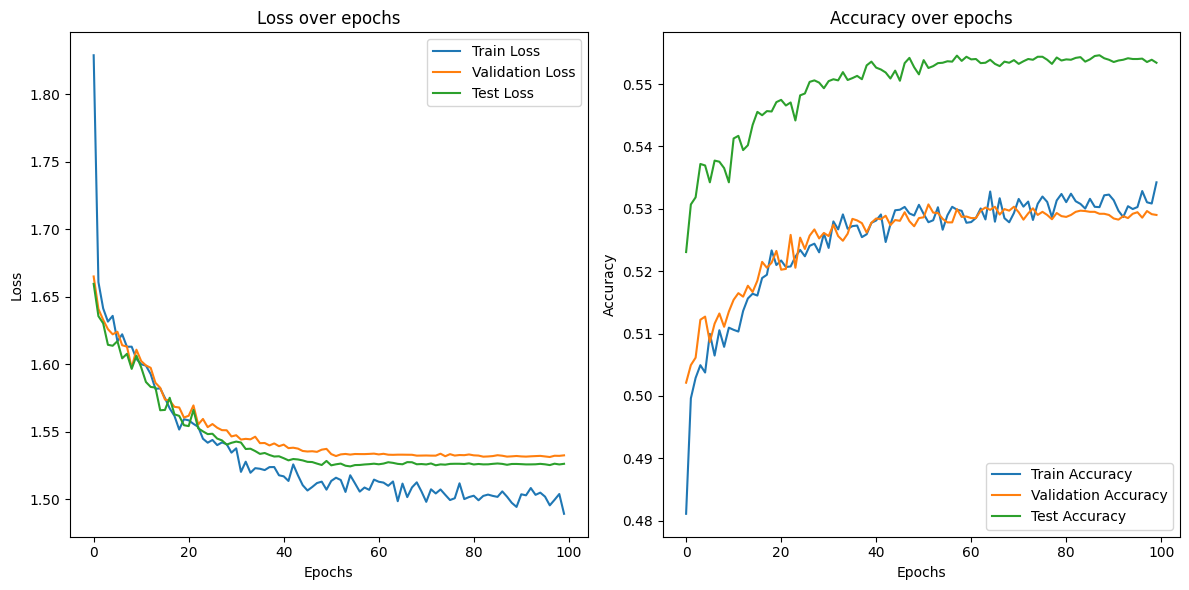

In [92]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [93]:
def load_model_and_vocab(model_path, vocab_path):
    # Load your trained model and vocabulary from the specified paths
    model = torch.load(model_path)
    vocab = torch.load(vocab_path)
    return model, vocab

def generate_passwords(model, vocab, num_passwords, password_length, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    model.to(device)
    stoi = vocab.get_stoi()  # Mapping from characters to indices
    itos = vocab.get_itos()  # Mapping from indices to characters
    sos_index = stoi['<sos>']  # Start of sequence token index
    passwords = []

    for _ in range(num_passwords):
        password = []
        input_seq = torch.tensor([[sos_index]], dtype=torch.long).to(device)

        for _ in range(password_length):
            with torch.no_grad():
                output = model(input_seq)
                probabilities = F.softmax(output[:, -1, :], dim=-1)
                next_token = torch.multinomial(probabilities, 1)
                password.append(itos[next_token.item()])
                next_token = next_token.view(1, 1)
                input_seq = torch.cat([input_seq, next_token], dim=1)

        passwords.append(''.join(password).replace('<eos>', ''))  # Remove end of sequence token if present

    return passwords


In [94]:
# Usage example:
# model, vocab = load_model_and_vocab('model.pth', 'vocab.pth')
generated_passwords = generate_passwords(model, vocab, num_passwords=10, password_length=12)
for pwd in generated_passwords:
    print(f"Generated Password: {pwd}")

Generated Password: enzhhooferba
Generated Password: rasame152391
Generated Password: hetininearey
Generated Password: hindegeoprin
Generated Password: toncosanittt
Generated Password: ipapucrlishe
Generated Password: imeriqlitese
Generated Password: riandichanun
Generated Password: amatianedizt
Generated Password: brrinkbaicha
